# 0. Imports and costants

In [1]:
############## AUTORELOAD MAGIC ###################
%load_ext autoreload
%autoreload 2
###################################################

############## FUNDAMENTAL MODULES ################
import json
from PIL import Image
import os
import sys
import copy
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
##################################################

############## DATA SCIENCE & ML MODULES ##########
from scipy.spatial.distance import cosine
###################################################

############## CONSTANTS ##########################
user = "patriziopalmisano" #"onurdenizguler"
dataset_directory = f"/Users/{user}/Library/CloudStorage/GoogleDrive-check.worthiness@gmail.com/My Drive/data/CT23_1A_checkworthy_multimodal_english_v2"
###################################################

# 1. Load and separate embeddings

Load embeddings from train/dev/test sets and separate them into two lists each based on the respective label

In [2]:
keys = ['train', 'dev', 'test']
embeddings_txt_yes = {}
embeddings_txt_no = {}
embeddings_img_yes = {}
embeddings_img_no = {}

for key in keys:
    embeddings_file = os.path.join(dataset_directory, f"embeddings_{key}_v2.pickle")
    with open(embeddings_file, 'rb') as f:
        embeddings_dict = pickle.load(f)
    
    jsonl_file = os.path.join(dataset_directory, f"CT23_1A_checkworthy_multimodal_english_{key}.jsonl")
    with open(jsonl_file, 'r') as f:
        json_data = f.readlines()
    
    mask = []

    for json_object in json_data:
        tweet = json.loads(json_object)
        class_label = tweet['class_label']

        if class_label == 'Yes':
            mask.append(True)
        else:
            mask.append(False)
            
    embeddings_txt_yes[key] = [embedding for embedding, mask_value in zip(embeddings_dict['txt'], mask) if mask_value]
    embeddings_txt_no[key] = [embedding for embedding, mask_value in zip(embeddings_dict['txt'], mask) if not mask_value]
    embeddings_img_yes[key] = [embedding for embedding, mask_value in zip(embeddings_dict['img'], mask) if mask_value]
    embeddings_img_no[key] = [embedding for embedding, mask_value in zip(embeddings_dict['img'], mask) if not mask_value]

    print("Length of " + key)
    print(len(embeddings_txt_yes[key]))
    print(len(embeddings_txt_no[key]))
    print(len(embeddings_img_yes[key]))
    print(len(embeddings_img_no[key]))

Length of train
820
1536
820
1536
Length of dev
87
184
87
184
Length of test
174
374
174
374


# 2. Distribution analysis
Get the cosine similarity for both classes

In [3]:
similarity_yes = {}
similarity_no = {}
for key in keys:
    similarity_yes[key] = [cosine(embeddings_img_yes[key][i], embeddings_txt_yes[key][i]) for i in range(len(embeddings_img_yes[key]))]
    similarity_no[key] = [cosine(embeddings_img_no[key][i], embeddings_txt_no[key][i]) for i in range(len(embeddings_img_no[key]))]

Plot the normalised similarity distribution and print its mean and standard deviation

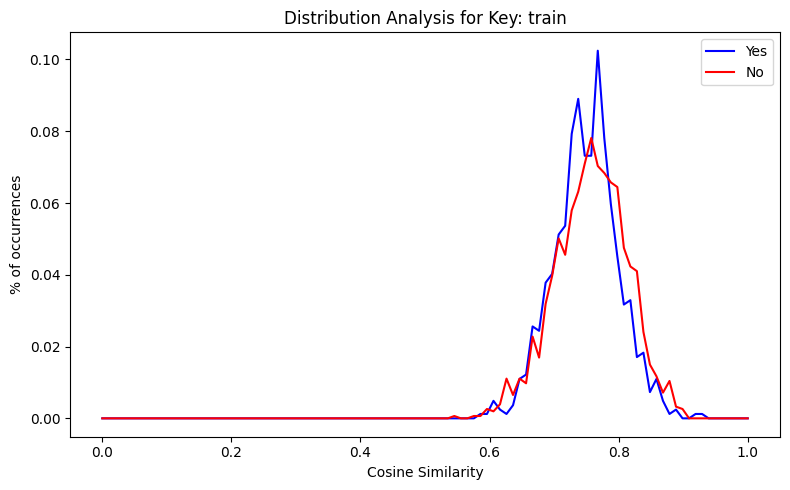

Yes Class:
Mean: 0.7471 Std: 0.0493
No Class:
Mean: 0.7546 Std: 0.0552


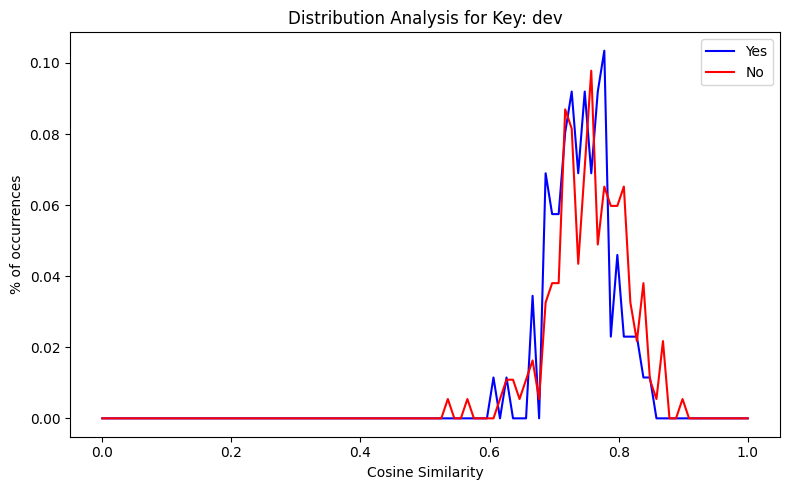

Yes Class:
Mean: 0.7413 Std: 0.0448
No Class:
Mean: 0.7522 Std: 0.0565


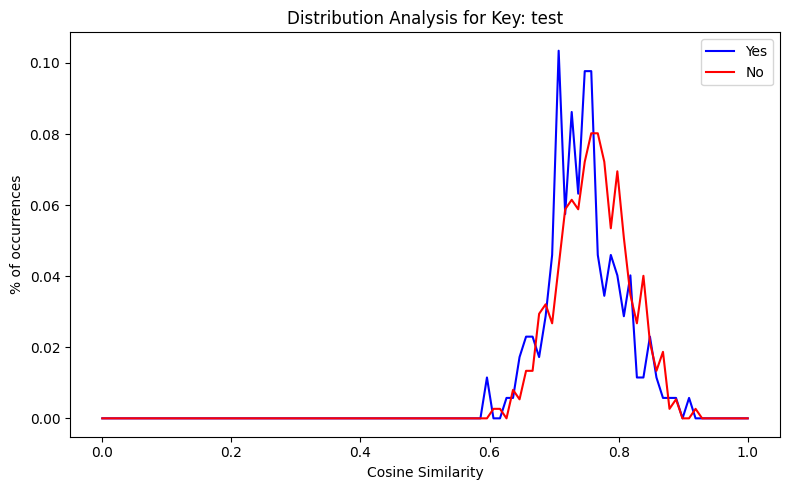

Yes Class:
Mean: 0.7427 Std: 0.0544
No Class:
Mean: 0.7588 Std: 0.0532


In [4]:
for key in keys:
    # Count the number of occurrences for each class
    yes_counts = np.histogram(similarity_yes[key], bins=100, range=(0, 1))[0]
    no_counts = np.histogram(similarity_no[key], bins=100, range=(0, 1))[0]

    # Normalisation
    yes_counts_norm = yes_counts / len(similarity_yes[key])
    no_counts_norm = no_counts / len(similarity_no[key])

    x = np.linspace(0, 1, num=100)

    plt.figure(figsize=(8, 5))
    plt.plot(x, yes_counts_norm, color='blue', label='Yes')
    plt.plot(x, no_counts_norm, color='red', label='No')

    plt.xlabel('Cosine Similarity')
    plt.ylabel('% of occurrences')
    plt.title(f'Distribution Analysis for Key: {key}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Calculate mean and standard deviation for each class
    mean_yes = np.mean(similarity_yes[key])
    std_yes = np.std(similarity_yes[key])
    mean_no = np.mean(similarity_no[key])
    std_no = np.std(similarity_no[key])

    print('Yes Class:')
    print(f'Mean: {mean_yes:.4f}' + f' Std: {std_yes:.4f}')
    print('No Class:')
    print(f'Mean: {mean_no:.4f}' + f' Std: {std_no:.4f}')

Plot the normalised similarity distribution as a histogram

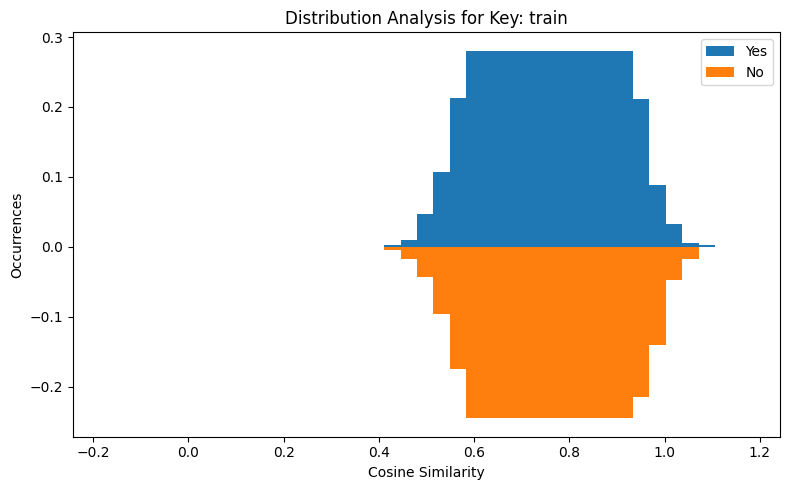

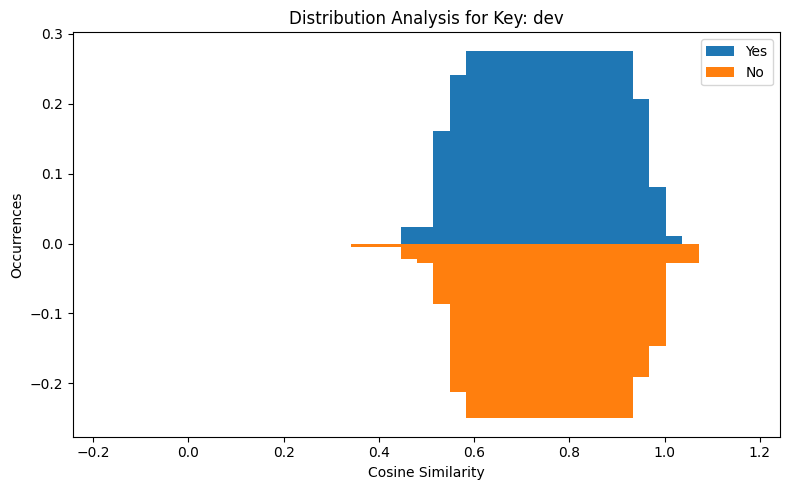

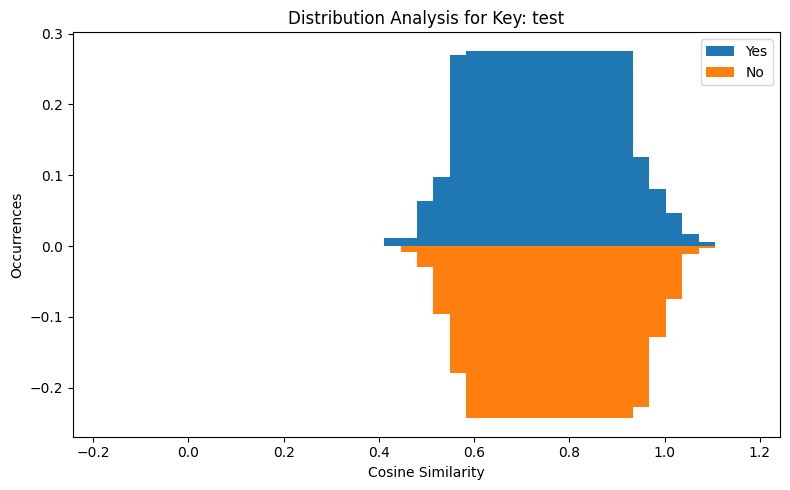

In [6]:
for key in keys:
    similarity_freq_yes = np.histogram(similarity_yes[key], bins=30, range=(0, 1))[0]
    similarity_freq_no = np.histogram(similarity_no[key], bins=30, range=(0, 1))[0]

    # Normalize the frequency distributions
    similarity_freq_yes_norm = similarity_freq_yes / len(similarity_yes[key])
    similarity_freq_no_norm = similarity_freq_no / len(similarity_no[key])

    plt.figure(figsize=(8, 5))
    x = np.linspace(0, 1, num=30)
    width = 0.35

    plt.bar(x, similarity_freq_yes_norm, width, label='Yes')
    plt.bar(x, -similarity_freq_no_norm, width, label='No')

    plt.xlabel('Cosine Similarity')
    plt.ylabel('Occurrences')
    plt.title(f'Distribution Analysis for Key: {key}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 3. Conclusions
The cosine similarity between the embeddings of images and text of the Yes and No classes of tweets follows a very similar distribution